In [1]:
#-------------------------
# Libs
#-------------------------
 
# External libs
# %matplotlib qt         Fuck this line right here.
import pymysql.cursors
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
sys.path.append("/home/omalleyian/Documents/energy_market_project/scripts")
from ercot_data_interface import ercot_data_interface

In [2]:
#-------------------------
# SQL environments
#-------------------------
 
HOST = "localhost"
USER = "root" 
PASSWORD = "Is79t5Is79t5"
DB = "ercot_data"

#-------------------------
# Functions
#-------------------------
"""
Make a connection to MySQL
Execute the MySQL query and return the resutls
"""

def execute_dict_query(query):
    connection = pymysql.connect(host=HOST, 
                                 user=USER, 
                                 password=PASSWORD, 
                                 db=DB, 
                                 port=3306,
                                 cursorclass=pymysql.cursors.DictCursor)
    
    try:
        with connection.cursor() as cursor:
            # Create a new record
            cursor.execute(query)
            result = cursor.fetchall()
            return result
    finally:
        connection.close()

 


In [3]:
# Query data sorted by date and hour. SLOW!
result_dict = execute_dict_query('select * from DAM_LMP0  \
                                where delivery_date < "2012-12-31" \
                                and delivery_date > "2011-01-01" \
                                order by delivery_date, hour_ending')

In [4]:
#Extract some data
prices1 = [i['n0001VICTOR'] for i in result_dict]
prices2 = [i['n0001'] for i in result_dict]
hours = [i['hour_ending'].total_seconds() for i in result_dict]
dates = [i['delivery_date'] for i in result_dict]
plt.plot(prices1)
plt.plot(prices2)
# plt.show()

In [15]:
# Percent Change
k = 24
p_t = np.array(prices1[k:])
p_tk = np.array(prices1[:-k])
v = np.log10(p_t) - np.log10(p_tk)
plt.plot(v)
# plt.show()

# MAPE = mean( (actual - forcast) / actual)

MAPE = np.mean(np.square(p_t-p_tk)/p_t)
print(MAPE)

[Decimal('27.58'), Decimal('26.12'), Decimal('25.81'), Decimal('26.63'), Decimal('26.74'), Decimal('26.29'), Decimal('25.06'), Decimal('29.66'), Decimal('29.55'), Decimal('32.10'), Decimal('32.11'), Decimal('30.24'), Decimal('27.17'), Decimal('25.44'), Decimal('24.63'), Decimal('24.34'), Decimal('25.59'), Decimal('29.30'), Decimal('44.61'), Decimal('39.17'), Decimal('34.98'), Decimal('34.20'), Decimal('31.03'), Decimal('30.14'), Decimal('26.11'), Decimal('24.12'), Decimal('24.99'), Decimal('26.20'), Decimal('27.92'), Decimal('22.65'), Decimal('33.34'), Decimal('39.88'), Decimal('29.13'), Decimal('22.81'), Decimal('22.94'), Decimal('24.04'), Decimal('24.26'), Decimal('22.24'), Decimal('21.22'), Decimal('24.02'), Decimal('24.07'), Decimal('26.55'), Decimal('40.17'), Decimal('32.61'), Decimal('28.77'), Decimal('25.49'), Decimal('30.87'), Decimal('28.39'), Decimal('20.82'), Decimal('20.58'), Decimal('20.49'), Decimal('20.86'), Decimal('23.09'), Decimal('28.03'), Decimal('38.55'), Decimal('

11.98669494391441608776131694


In [6]:
# Basic data plot
price1 = [float(i['AMNCOWD_8']) for i in result_dict]
price2 = [float(i['AZLES_K']) for i in result_dict]
price3 = [float(i['n0001']) for i in result_dict]

plt.plot(price1, label='1')
plt.plot(price2, label='2')
plt.plot(price3, label='2')
plt.legend()
# plt.show()


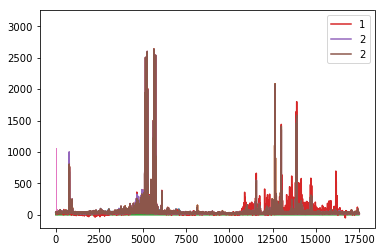

In [7]:
# Histogram
plt.hist(price1, 500)
plt.show()

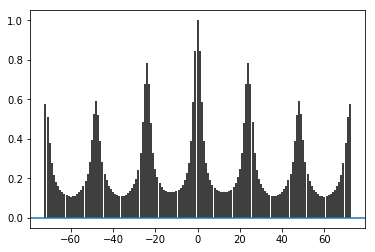

In [8]:
# Autocorrelation
plt.acorr(price1, maxlags=72)
plt.show()

In [9]:
np.mean(price1)

43.287123585229224

In [10]:
#extend this to get prices at different lags e.g. k-1, k-2, k-3
max_lag = 168
p_t = prices1[max_lag:]
X = []
for k in np.arange(0, max_lag, 24):
    t_k = np.array(prices1[(max_lag-k):-k], dtype='float')
    X.append(t_k)
X = np.swapaxes(np.array(X[1:]), 0, 1)
Y = [float(i) for i in p_t]
# use sklearn.LinearRegression to fit (X, Y)

regr = linear_model.LinearRegression()
regr.fit(X,Y)

print regr.predict(X)
plt.plot(X)
# plt.show()


[ 28.52689124  26.88588505  26.08917088 ...,  27.35143936  29.09992171
  25.80891015]


In [11]:
# Mean Model
# Given list X and time t
# Return mean of X from 0 to t

def mean_model(X, t):
    return np.mean(X[:t])

print mean_model(prices1, 24)

29.52041666666666666666666667


In [12]:
# Random Walk Model
# Given list X and time t
# Return element of X at time t-1

def random_walk(X, t):
    return X[t-1]

print random_walk(prices1, 24)

30.14


In [13]:
# Moving Average Model
# Given a list X, time t, and m number of observations
# Return the value of Y at time t of the previous m elements in X.

def moving_average(X, t, m):
    s = sum(X[(t-m):t])
    avg = s/m
    return avg

print moving_average(prices1, 24, 24)
    
    

29.52041666666666666666666667


In [14]:
ercot = ercot_data_interface(password="Is79t5Is79t5")
nodes_crr = ercot.get_CRR_nodes()
nodes_all = ercot.all_nodes
nodes_source = ercot.get_sources_sinks()
df = ercot.query_prices(nodes_crr[0:5], "2011-01-01","2012-01-01")

n = nodes_source[10]
neighbor = ercot.get_nearest_CRR_neighbors(n)

print n
print neighbor

print len(nodes_all)
print len(nodes_crr)


#print df

PC_SOUTH_2
['LZ_WEST', 'PC_SOUTH_2', 'PC_SOUTH_3', 'PC_SOUTH_K', 'PC_SOUTH_KC']
12870
3588
